# AI-driven morphoclimatic regional frequency modelling of sub-daily rainfall-extremes
**Authors**: Chiara Angileri, Niccolò Marzi, Shola Oshodi

**DOUBTS**
- Calcolare alpha e beta per ogni stazione con il fit di scipy? Vanno messe due nuove colonne nel dataset? Se c'è una sola osservazione non posso fare il fit => uniforme? (alpha=1, beta=1)
- Output: AMS o alpha e beta?
- Initial guess? 
- Alpha e beta predetti per ogni stazione come vanno paragonati con quelli "veri"? Intervallo di confidenza sulla media o sui parametri (questo come si calcola) ?
- Come si fa inferenza su più distribuzioni? Quali metriche?
- 20 epoche e 2 hidden impara come 2 epoche e 0 hidden

**TO DO**
- provare con solo MAP in input
- pca?
- nel test ogni stazione ha senso che ci sia una sola volta, tanto l'output sarà sempre lo stesso


# 0. Importing libraries

In [1]:
colab = False

if colab:
    !pip install fitter
    !pip install pydot
    !pip install graphviz
    from pathlib import Path
    from google.colab import drive
    drive.mount('/content/drive')

import pandas as pd
import numpy as np
from itertools import chain
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics

from fitter import Fitter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from tensorflow.keras import callbacks
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy import stats

C:\Users\chiar\AppData\Local\Temp\ipykernel_3760\3213066549.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# 1. Load and inspect the dataset

## 1.1. Load data

In [41]:
if colab:
    data_folder = Path.cwd() / "drive" / "MyDrive" / "A3I" / "data"
    dataset_path = data_folder.joinpath("AMS_descritt_noSM_meltD_adim.csv")
    dataset_indexes_test = data_folder.joinpath("gumMap_statbench_Gumfit_NEW.csv")
else:
    dataset_path = "data/AMS_descritt_noSM_meltD_adim.csv"
    dataset_indexes_test = "data/gumMap_statbench_Gumfit_NEW.csv"

df = pd.read_csv(dataset_path, sep=',', encoding='utf-8')
df.drop(df.columns[[0]], axis=1, inplace=True)

df_indexes_test = pd.read_csv(dataset_indexes_test, sep=',', encoding='utf-8') #dataset used to extract the ids for test

print(df.columns)

Index(['ID', 'Nome', 'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y', 'duration[h]', 'AMS',
       'mean_IdD', 'loc', 'scale', '99perc', '95perc', '80perc'],
      dtype='object')


In [42]:
df.head()

,ID,Nome,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),...,X,Y,duration[h],AMS,mean_IdD,loc,scale,99perc,95perc,80perc
0,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,1.221239,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
1,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,0.778761,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
2,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.219018,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
3,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,0.979995,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
4,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.153287,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679


In [43]:
# Clean the dataset from the columns that are not useful
to_remove = ['Nome', '99perc', '95perc', '80perc']
df = df.drop(to_remove, axis=1, inplace=False)

# Unique duration values
DURATION = df['duration[h]'].unique()
print('Durations: ', DURATION)

Durations:  [ 1  3  6 12 24]


## 1.2. Preprocess and split the dataset

In [44]:
def standardize(df):
    
    features_not_to_scale = ['ID', 'AMS', 'mean_IdD', 'loc', 'scale', 'duration[h]']
    features_to_scale = df.columns.drop(features_not_to_scale)

    order_columns = features_not_to_scale + list(features_to_scale)

    #scaler = MinMaxScaler() #min max scaler to have values in range [0, 1]
    scaler = StandardScaler() #standard scaler to have values with mean 0 and std 1

    scaled_data = scaler.fit_transform(df[features_to_scale])
    non_scaled_data = df[features_not_to_scale]
    std_df = np.concatenate([non_scaled_data, scaled_data], axis=1)

    # convert to dataframe
    std_df = pd.DataFrame(std_df, columns=order_columns)
    
    return std_df

### Split the dataset into train, validation and test

In [45]:
# Take the first 100 ID from df2 and use them to create the test sets
test_ID = df_indexes_test['ID'].to_list()[:100]

test_df = df[df['ID'].isin(test_ID)]
test_df.reset_index(drop=True, inplace=True)

# Drop the test set from std_dfs and then create the train sets and validation sets
df = df.drop(df[df['ID'].isin(test_ID)].index)
df.reset_index(drop=True, inplace=True)

validation_split = 0.1
df = df.sort_values(by=['ID'])

train_df, val_df = train_test_split(df, test_size=validation_split, shuffle=False)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [46]:
train_df.head()

,ID,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),OrogrAdri_stdev(m),...,MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,duration[h],AMS,mean_IdD,loc,scale
0,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,426.348085,...,577.581116,484.327515,281.33847,633069.81,4890553.68,1,1.221239,28.250,0.890564,0.184415
1,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,426.348085,...,577.581116,484.327515,281.33847,633069.81,4890553.68,24,0.680425,199.875,0.859361,0.219803
2,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,426.348085,...,577.581116,484.327515,281.33847,633069.81,4890553.68,24,0.855535,199.875,0.859361,0.219803
3,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,426.348085,...,577.581116,484.327515,281.33847,633069.81,4890553.68,24,0.945591,199.875,0.859361,0.219803
4,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,426.348085,...,577.581116,484.327515,281.33847,633069.81,4890553.68,24,1.518449,199.875,0.859361,0.219803


### Standardize datasets

In [47]:
train_df_std = standardize(train_df)
val_df_std = standardize(val_df)
test_df_std = standardize(test_df)

In [48]:
# column ID must be integer
train_df_std['ID'] = train_df_std['ID'].astype(int)
val_df_std['ID'] = val_df_std['ID'].astype(int)
test_df_std['ID'] = test_df_std['ID'].astype(int)

# column duration[h] must be integer
train_df_std['duration[h]'] = train_df_std['duration[h]'].astype(int)
val_df_std['duration[h]'] = val_df_std['duration[h]'].astype(int)
test_df_std['duration[h]'] = test_df_std['duration[h]'].astype(int)

In [49]:
train_df_std.head()

,ID,AMS,mean_IdD,loc,scale,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
0,5001,1.221239,28.250,0.890564,0.184415,1,1.491097,0.251105,0.104265,-0.433165,...,-0.79254,1.031064,1.012611,0.623256,2.169919,4.627821,1.780453,4.58539,0.512238,-0.713267
1,5001,0.680425,199.875,0.859361,0.219803,24,1.491097,0.251105,0.104265,-0.433165,...,-0.79254,1.031064,1.012611,0.623256,2.169919,4.627821,1.780453,4.58539,0.512238,-0.713267
2,5001,0.855535,199.875,0.859361,0.219803,24,1.491097,0.251105,0.104265,-0.433165,...,-0.79254,1.031064,1.012611,0.623256,2.169919,4.627821,1.780453,4.58539,0.512238,-0.713267
3,5001,0.945591,199.875,0.859361,0.219803,24,1.491097,0.251105,0.104265,-0.433165,...,-0.79254,1.031064,1.012611,0.623256,2.169919,4.627821,1.780453,4.58539,0.512238,-0.713267
4,5001,1.518449,199.875,0.859361,0.219803,24,1.491097,0.251105,0.104265,-0.433165,...,-0.79254,1.031064,1.012611,0.623256,2.169919,4.627821,1.780453,4.58539,0.512238,-0.713267


In [50]:
train_df_std.describe()

,ID,AMS,mean_IdD,loc,scale,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
count,233218.000000,233218.000000,233218.000000,233218.000000,2.332180e+05,233218.000000,2.332180e+05,2.332180e+05,2.332180e+05,2.332180e+05,...,2.332180e+05,2.332180e+05,2.332180e+05,2.332180e+05,2.332180e+05,2.332180e+05,2.332180e+05,2.332180e+05,2.332180e+05,2.332180e+05
mean,11047.209328,0.999994,57.052651,0.840404,2.670913e-01,9.199200,7.507042e-17,7.409548e-17,-3.314798e-17,3.197805e-16,...,-4.523724e-16,-2.412978e-16,1.774392e-16,7.799524e-17,-7.019572e-17,1.413664e-17,-2.924822e-18,1.160179e-16,8.111505e-16,-5.490865e-15
std,4333.130131,0.375311,31.051531,0.034366,5.204271e-02,8.280664,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,5001.000000,0.008228,5.200000,0.563792,6.394417e-304,1.000000,-1.061720e+00,-1.230453e+00,-1.400119e+00,-1.588764e+00,...,-1.386613e+00,-1.471702e+00,-1.677331e+00,-1.834339e+00,-1.613136e+00,-4.798978e-01,-1.574433e+00,-6.312755e-01,-1.985384e+00,-1.780799e+00
25%,8094.000000,0.746687,34.984444,0.820754,2.357013e-01,3.000000,-7.450225e-01,-8.616555e-01,-9.477065e-01,-7.307816e-01,...,-8.936858e-01,-5.806414e-01,-7.799818e-01,-7.189705e-01,-7.835092e-01,-4.531067e-01,-8.066373e-01,-5.114469e-01,-9.065087e-01,-7.796086e-01
50%,12005.000000,0.931278,49.674286,0.841520,2.668687e-01,6.000000,-2.934347e-01,-1.262639e-01,3.152787e-02,7.104603e-02,...,-4.642899e-02,-1.402476e-01,-1.361465e-01,-1.810079e-01,-2.345443e-01,-4.210953e-01,-2.259545e-01,-4.328924e-01,1.538823e-01,-2.911280e-01
75%,16065.000000,1.171738,70.343750,0.862298,2.976202e-01,12.000000,4.626625e-01,6.164214e-01,7.001068e-01,6.817685e-01,...,6.758903e-01,3.750492e-01,6.410975e-01,5.143236e-01,5.747680e-01,-2.262652e-01,6.329709e-01,-9.903266e-02,7.807107e-01,7.872395e-01
max,20034.000000,6.288661,318.742857,1.000000,6.725157e-01,24.000000,5.303011e+00,3.753508e+00,2.939412e+00,3.556897e+00,...,2.546467e+00,5.233349e+00,3.650529e+00,3.278702e+00,4.315496e+00,7.291909e+00,3.516737e+00,6.103627e+00,2.150008e+00,2.505157e+00


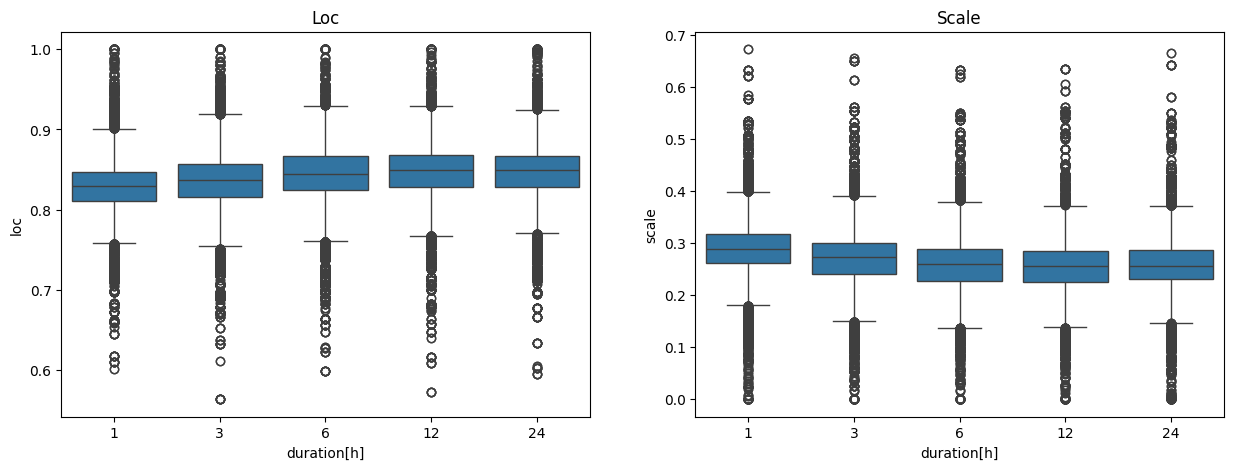

In [51]:
#boxplot of loc and scale
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(x='duration[h]', y='loc', data=train_df_std, ax=ax[0])
ax[0].set_title('Loc')

sns.boxplot(x='duration[h]', y='scale', data=train_df_std, ax=ax[1])
ax[1].set_title('Scale')

plt.show()

In [52]:
AMS_count = train_df_std.groupby(['ID','duration[h]'])['AMS'].count()
AMS_count = pd.DataFrame(AMS_count)
AMS_count.columns = ['count']
AMS_count['loc'] = train_df_std.groupby(['ID','duration[h]'])['loc'].mean() #prendo la media tanto lo stesso valore è ripetuto
AMS_count['scale'] = train_df_std.groupby(['ID','duration[h]'])['scale'].mean()

AMS_count.head(15)

count       loc     scale
ID   duration[h]                           
5001 1                2  0.890564  0.184415
     3                4  0.925308  0.129267
     6                4  0.932067  0.124795
     12               4  0.906658  0.175087
     24               4  0.859361  0.219803
5002 1               23  0.823918  0.287186
     3               23  0.783417  0.300108
     6               23  0.782840  0.333148
     12              23  0.804177  0.335036
     24              23  0.788515  0.355437
5003 1               55  0.820118  0.333625
     3               56  0.802589  0.378693
     6               56  0.806101  0.377994
     12              56  0.817565  0.370967
     24              56  0.818996  0.371627

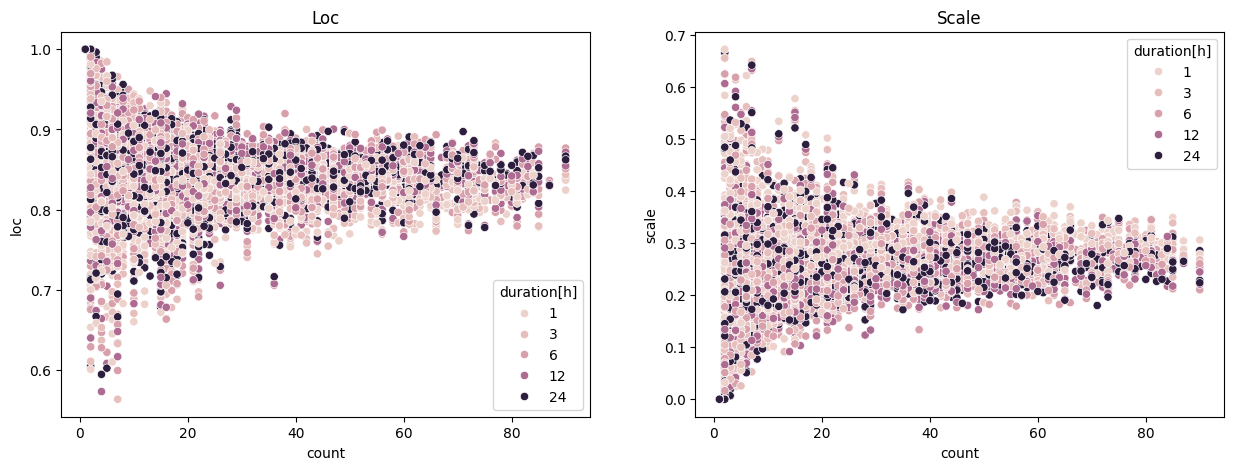

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.scatterplot(x='count', y='loc', data=AMS_count, ax=ax[0], hue='duration[h]')
ax[0].set_title('Loc')

sns.scatterplot(x='count', y='scale', data=AMS_count, ax=ax[1], hue='duration[h]')
ax[1].set_title('Scale')

plt.show()

## 1.4. Prepare data for training

In [54]:
# sort the dataframes by ID and then by duration
train_df_std = train_df_std.sort_values(by=['ID', 'duration[h]'])
val_df_std = val_df_std.sort_values(by=['ID', 'duration[h]'])
test_df_std = test_df_std.sort_values(by=['ID', 'duration[h]'])

# create a dict to store the indexes of same durations
durations_indexes_train = {}
for duration in DURATION:
    durations_indexes_train[duration] = train_df_std[train_df_std['duration[h]'] == duration].index

durations_indexes_val = {}
for duration in DURATION:
    durations_indexes_val[duration] = val_df_std[val_df_std['duration[h]'] == duration].index

durations_indexes_test = {}
for duration in DURATION:
    durations_indexes_test[duration] = test_df_std[test_df_std['duration[h]'] == duration].index

In [55]:
train_df_std.columns

Index(['ID', 'AMS', 'mean_IdD', 'loc', 'scale', 'duration[h]',
       'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y'],
      dtype='object')

In [56]:
# take all the columns except 'ID', 'AMS', 'mean_IdD' as input, and 'AMS' as output
columns = train_df_std.columns
input_columns = columns[5:] #['MAP(mm)', 'duration[h]'] #['loc', 'scale'] 
output_column = 'AMS'
parameters_columns = ['ID', 'duration[h]', 'loc', 'scale']
print('Input columns: ', input_columns)

Input columns:  Index(['duration[h]', 'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y'],
      dtype='object')


In [57]:
inputs_train = train_df_std[input_columns]
outputs_train = train_df_std[output_column]
parameters_train = train_df_std[parameters_columns]

inputs_val = val_df_std[input_columns]
outputs_val = val_df_std[output_column]
parameters_val = val_df_std[parameters_columns]

inputs_test = test_df_std[input_columns]
outputs_test = test_df_std[output_column]
parameters_test = test_df_std[parameters_columns]

In [58]:
'''for duration in DURATION:
    for id in train_df_std['ID'].unique():
        if len(train_df_std[train_df_std['ID'] == id]) < 10:
            #delete the id from the train set
            train_df_std = train_df_std[train_df_std['ID'] != id]'''


"for duration in DURATION:\n    for id in train_df_std['ID'].unique():\n        if len(train_df_std[train_df_std['ID'] == id]) < 10:\n            #delete the id from the train set\n            train_df_std = train_df_std[train_df_std['ID'] != id]"

In [59]:
inputs_train

,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),OrogrAdri_stdev(m),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
0,1,1.491097,0.251105,0.104265,-0.433165,2.356325,0.207127,-0.602938,0.327227,0.547504,...,-0.792540,1.031064,1.012611,0.623256,2.169919,4.627821,1.780453,4.585390,0.512238,-0.713267
15,1,1.491097,0.251105,0.104265,-0.433165,2.356325,0.207127,-0.602938,0.327227,0.547504,...,-0.792540,1.031064,1.012611,0.623256,2.169919,4.627821,1.780453,4.585390,0.512238,-0.713267
5,3,1.491097,0.251105,0.104265,-0.433165,2.356325,0.207127,-0.602938,0.327227,0.547504,...,-0.792540,1.031064,1.012611,0.623256,2.169919,4.627821,1.780453,4.585390,0.512238,-0.713267
6,3,1.491097,0.251105,0.104265,-0.433165,2.356325,0.207127,-0.602938,0.327227,0.547504,...,-0.792540,1.031064,1.012611,0.623256,2.169919,4.627821,1.780453,4.585390,0.512238,-0.713267
7,3,1.491097,0.251105,0.104265,-0.433165,2.356325,0.207127,-0.602938,0.327227,0.547504,...,-0.792540,1.031064,1.012611,0.623256,2.169919,4.627821,1.780453,4.585390,0.512238,-0.713267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233201,24,1.385034,0.772005,0.693361,1.147691,-0.492610,0.078161,1.879655,0.615505,1.600197,...,1.269074,1.497205,3.081015,3.278702,-0.149450,1.500728,0.805394,1.653221,-1.793283,1.246819
233202,24,1.385034,0.772005,0.693361,1.147691,-0.492610,0.078161,1.879655,0.615505,1.600197,...,1.269074,1.497205,3.081015,3.278702,-0.149450,1.500728,0.805394,1.653221,-1.793283,1.246819
233203,24,1.385034,0.772005,0.693361,1.147691,-0.492610,0.078161,1.879655,0.615505,1.600197,...,1.269074,1.497205,3.081015,3.278702,-0.149450,1.500728,0.805394,1.653221,-1.793283,1.246819
233204,24,1.385034,0.772005,0.693361,1.147691,-0.492610,0.078161,1.879655,0.615505,1.600197,...,1.269074,1.497205,3.081015,3.278702,-0.149450,1.500728,0.805394,1.653221,-1.793283,1.246819


# 2. Model definition

#### Base model

In [60]:
def build_nn_gumbel_model(input_shape, hidden):
    model_in = keras.Input(shape=input_shape, dtype='float64')
    x = model_in
    
    for h in hidden:
        x = layers.Dense(h, activation='relu')(x)
    
    mu_logsig = layers.Dense(2, activation='linear')(x)

    lf = lambda t: tfp.distributions.Gumbel(loc=t[:, :1], scale=(1e-6)+tf.math.exp(t[:, 1:]))
    model_out = tfp.layers.DistributionLambda(lf)(mu_logsig)
    model = keras.Model(model_in, model_out)
    
    return model

# 3. Metrics 

In [106]:
def sample_metrics(dist, y, label, color, plot = True):
    num_samples = 1
    y_pred = dist.sample(num_samples).numpy().ravel()
    
    mae = metrics.mean_absolute_error(y, y_pred)
    ks_statistics, _ = stats.ks_2samp(y, y_pred)

    if plot:
        plt.hist(y, bins='auto', alpha=0.7, label=label, density=True, color='green');
        #sns.kdeplot(y_pred, label='Estimated sample', fill=True)
        plt.hist(y_pred, bins='auto', alpha=0.5, label='Predicted', density=True, color=color);
        plt.legend()
        plt.show()

    return mae, ks_statistics

def plot_series(data, labels=None, predictions=None, figsize=None, filled_version=None, std=None, ci=None, title=None, ylim=None):
    
    plt.figure(figsize=figsize)
    plt.plot(data.index, data.values, zorder=0)
    
    if filled_version is not None:
        filled = filled_version.copy()
        filled[~data['value'].isnull()] = np.nan
        plt.scatter(filled.index, filled, marker='.', c='tab:orange', s=5);
    
    # Plot standard deviations
    if std is not None:
        lb = data.values.ravel() - std.values.ravel()
        ub = data.values.ravel() + std.values.ravel()
        plt.fill_between(data.index, lb, ub, alpha=0.3, label='+/- std')
    
    # Plot confidence intervals
    if ci is not None:
        lb = ci[0].ravel()
        ub = ci[1].ravel()
        plt.fill_between(data.index, lb, ub, alpha=0.3, label='C.I.')
    
    # Rotated x ticks
    plt.xticks(rotation=45)
    
    # Plot labels
    if labels is not None:
        plt.scatter(labels.values, data.loc[labels], color='red', zorder=2, s=5)
    
    # Predictions
    if predictions is not None:
        plt.scatter(predictions.values, data.loc[predictions], color='black', alpha=.4, zorder=3, s=5)
    
    # Force y limits
    if ylim is not None:
        plt.ylim(*ylim)
    
    plt.grid(linestyle=':')
    plt.title(title)
    plt.tight_layout()

def percentage_in_ci(inputs, y, dist, confidence, distribution = 'gumbel', start = None, end = None, plot = True, num_samples=1):
    
    if start is None:
        start = 0
    if end is None:
        end = len(y)

    inputs = inputs.reset_index()

    if distribution == 'gumbel':
        lb, ub = stats.gumbel_r.interval(confidence, loc=dist.loc, scale=dist.scale)
        mean_dist = dist.mean().numpy().ravel()
        y_pred = dist.sample(num_samples).numpy().ravel()

        if plot:
            plot_series(pd.Series(index=inputs[start:end].index, data=mean_dist[start:end]), ci=(lb[start:end], ub[start:end]), figsize=(12,6))
            plt.scatter(inputs[start:end].index, y_pred[start:end], marker='o', color='blue', label='Predicted');
            plt.scatter(inputs[start:end].index, y[start:end], marker='x', color='red', label='True');
            plt.legend()
            plt.show()
    
        count_true = 0
        for i in range(len(y)):
            if lb[i] <= y[i] <= ub[i]:
                count_true += 1
        
        true_guess = count_true/len(y)*100

        return true_guess
    
def parameters_metrics(dist, true_parameters, indexes = None, duration = None, plot=True, calculate_metrics = True, remove_outliers = False):

    loc_pred_tot = dist.loc.numpy().ravel()
    loc_true_tot = true_parameters['loc'].to_numpy()
    loc_max = loc_pred_tot.max()
    loc_min = loc_pred_tot.min()

    scale_pred_tot = dist.scale.numpy().ravel()
    scale_true_tot = true_parameters['scale'].to_numpy()
    scale_max = scale_pred_tot.max()
    scale_min = scale_pred_tot.min()

    

    # loc_pred = dist.loc.numpy()[indexes].ravel()
    # loc_true = true_parameters['loc'][indexes].to_numpy()
    # loc_max = loc_pred.max() 
    # loc_min = loc_pred.min()

    # scale_pred = dist.scale.numpy()[indexes].ravel()
    # scale_true = true_parameters['scale'][indexes].to_numpy()
    # scale_max = scale_pred.max() 
    # scale_min = scale_pred.min()
    
    
    
    
    if plot:

        parameters = true_parameters.copy()
        parameters['loc_pred'] = loc_pred_tot
        parameters['scale_pred'] = scale_pred_tot

        if remove_outliers:
            out_indexes = np.where(loc_true_tot > 500) #change value
            loc_pred_tot = np.delete(loc_pred_tot, out_indexes)
            loc_true_tot = np.delete(loc_true_tot, out_indexes)

            out_indexes = np.where(scale_true_tot > 1500) #change value
            scale_pred_tot = np.delete(scale_pred_tot, out_indexes)
            scale_true_tot = np.delete(scale_true_tot, out_indexes)

        fig, ax = plt.subplots(1, 2, figsize=(15, 5))

        #ax[0].scatter(loc_pred, loc_true, color='blue', label='loc', marker='o')
        sns.scatterplot(x='loc_pred', y='loc', data=parameters, hue='duration[h]', ax=ax[0], marker='o')
        x = np.linspace(loc_min, loc_max, 100)
        ax[0].plot(x, x, color='black', linestyle='--')
        ax[0].set_xlabel('Predicted loc')
        ax[0].set_ylabel('True loc')
        ax[0].set_title('Scatter plot of the predicted loc values')
        
        #ax[1].scatter(scale_pred, scale_true, color='blue', label='scale', marker='o')
        sns.scatterplot(x='scale_pred', y='scale', data=parameters, hue='duration[h]', ax=ax[1], marker='o')
        x = np.linspace(scale_min, scale_max, 100)
        ax[1].plot(x, x, color='black', linestyle='--')
        ax[1].set_xlabel('Predicted scale')
        ax[1].set_ylabel('True scale')
        ax[1].set_title('Scatter plot of the predicted scale values')
        plt.show()

    if calculate_metrics:
        if duration is not None:
            indexes = indexes[duration]

            loc_pred = loc_pred_tot[indexes]
            loc_true = loc_true_tot[indexes]

            scale_pred = scale_pred_tot[indexes]
            scale_true = scale_true_tot[indexes]

            loc_biasr = ((loc_true - loc_pred) / loc_true).mean()
            loc_rmse = metrics.root_mean_squared_error(loc_true, loc_pred)
            loc_pcc = np.corrcoef(loc_true, loc_pred)[0, 1]

            scale_biasr = ((scale_true - scale_pred) / scale_true).mean()
            scale_rmse = metrics.root_mean_squared_error(scale_true, scale_pred)
            scale_pcc = np.corrcoef(scale_true, scale_pred)[0, 1]

            return (loc_biasr, loc_rmse, loc_pcc), (scale_biasr, scale_rmse, scale_pcc)

        metrics_loc_durations = {}
        metrics_scale_durations = {}
        for d in DURATION:
            ids = indexes[d]

            loc_pred = loc_pred_tot[ids]
            loc_true = loc_true_tot[ids]

            scale_pred = scale_pred_tot[ids]
            scale_true = scale_true_tot[ids]

            loc_biasr = ((loc_true - loc_pred) / loc_true).mean()
            loc_rmse = metrics.root_mean_squared_error(loc_true, loc_pred)
            loc_pcc = np.corrcoef(loc_true, loc_pred)[0, 1]

            scale_biasr = ((scale_true - scale_pred) / scale_true).mean()
            scale_rmse = metrics.root_mean_squared_error(scale_true, scale_pred)
            scale_pcc = np.corrcoef(scale_true, scale_pred)[0, 1]

            metrics_loc_durations[d] = [loc_biasr, loc_rmse, loc_pcc]
            metrics_scale_durations[d] = [scale_biasr, scale_rmse, scale_pcc]

        # create a dataframe
        metrics_loc_durations = pd.DataFrame(metrics_loc_durations, index=['biasr', 'rmse', 'pcc'])
        metrics_scale_durations = pd.DataFrame(metrics_scale_durations, index=['biasr', 'rmse', 'pcc'])

        return metrics_loc_durations, metrics_scale_durations

    return None

# 4. Training

In [62]:
def train_nn_model(model, X, y, batch_size, loss, lr, verbose=0, patience=10, validation_data=None, **fit_params):
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss)
    
    # Build the early stop callback
    cb = []
    if validation_data is not None:
        cb += [callbacks.EarlyStopping(patience=patience, restore_best_weights=True)]
    
    # Train the model
    history = model.fit(X, y, batch_size=batch_size, callbacks=cb, validation_data=validation_data, verbose=verbose, **fit_params)
    
    return history

def plot_training_history(history=None, figsize=None, print_final_scores=True):
    plt.figure(figsize=figsize)
    for metric in history.history.keys():
        plt.plot(history.history[metric], label=metric)
    
    if len(history.history.keys()) > 0:
        plt.legend()
    plt.xlabel('epochs')
    plt.grid(linestyle=':')
    plt.tight_layout()
    plt.show()
    
    if print_final_scores:
        trl = history.history["loss"][-1]
        s = f'Final loss: {trl:.4f} (training)'
        if 'val_loss' in history.history:
            vll = history.history["val_loss"][-1]
            s += f', {vll:.4f} (validation)'
        print(s)

## Training

In [63]:
X_train = inputs_train.values
y_train  = outputs_train.values
X_val = inputs_val.values
y_val = outputs_val.values
X_test = inputs_test.values
y_test = outputs_test.values

Training the model without the guesses...
Epoch 1/90
456/456 [==============================] - 2s 3ms/step - loss: 0.5110 - val_loss: 0.5607
Epoch 2/90
456/456 [==============================] - 1s 3ms/step - loss: 0.3283 - val_loss: 0.6897
Epoch 3/90
456/456 [==============================] - 1s 3ms/step - loss: 0.3164 - val_loss: 0.7310
Epoch 4/90
456/456 [==============================] - 1s 3ms/step - loss: 0.3131 - val_loss: 0.5045
Epoch 5/90
456/456 [==============================] - 1s 3ms/step - loss: 0.3140 - val_loss: 0.5206
Epoch 6/90
456/456 [==============================] - 1s 3ms/step - loss: 0.3096 - val_loss: 0.9731
Epoch 7/90
456/456 [==============================] - 1s 3ms/step - loss: 0.3106 - val_loss: 1.0837
Epoch 8/90
456/456 [==============================] - 1s 3ms/step - loss: 0.3107 - val_loss: 1.2264
Epoch 9/90
456/456 [==============================] - 1s 3ms/step - loss: 0.3067 - val_loss: 0.7361
Epoch 10/90
456/456 [==============================] - 1s 

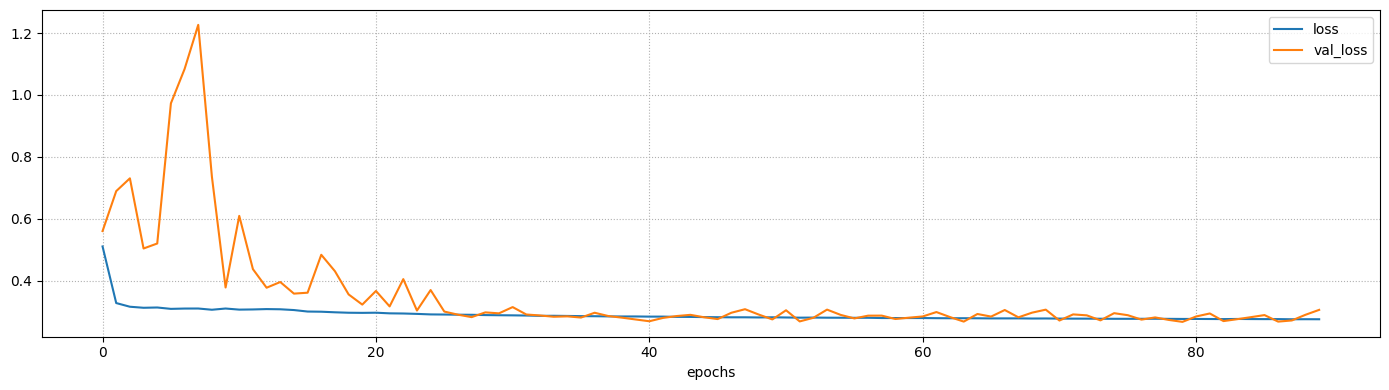

Final loss: 0.2760 (training), 0.3063 (validation)


In [64]:
# Parameters for the training
batch_size = 512
epochs = 90
lr = 1e-3
loss_prof = lambda y_true, dist: -dist.log_prob(y_true)

print('Training the model without the guesses...')
model = build_nn_gumbel_model(input_shape=(X_train.shape[1],), hidden=[128,256]) #[256,128]
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, mode='auto', min_delta=1e-3)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss_prof)
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), callbacks=[callback], verbose=1)
plot_training_history(history, figsize=(14, 4))

# Eval

* Train evaluation

Evaluating the models on training set...


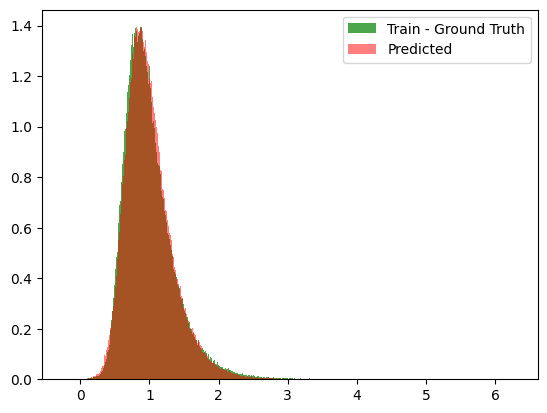

Train:
MAE: 0.38
KS statistics: 0.02


In [65]:
print('Evaluating the models on training set...')

dist_train = model(X_train)
mae_train, ks_statist_train = sample_metrics(dist_train, y_train, 'Train - Ground Truth', 'red')
print('Train:')
print(f'MAE: {mae_train:.2f}')
print(f'KS statistics: {ks_statist_train:.2f}')

# Store the results in a dataframe
results = pd.DataFrame(columns=['Split', 'MAE', 'KS statistics'])

train_no_guess = ['Train', mae_train, ks_statist_train]
results.loc[0] = train_no_guess

* Validation evaluation

Evaluating the models on validation set...


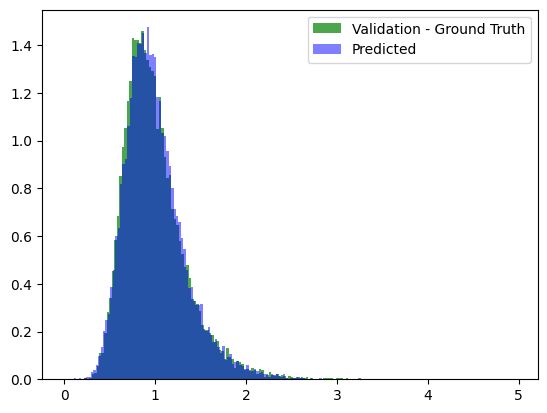

Validation:
MAE: 0.37
KS statistics: 0.02


In [66]:
print('Evaluating the models on validation set...')

dist_val = model(X_val)
mae_val, ks_statist_val = sample_metrics(dist_val, y_val, 'Validation - Ground Truth', 'blue')
print('Validation:')
print(f'MAE: {mae_val:.2f}')
print(f'KS statistics: {ks_statist_val:.2f}')

val_no_guess = ['Validation', mae_val, ks_statist_val]
results.loc[1] = val_no_guess

Evaluating the models on test set...


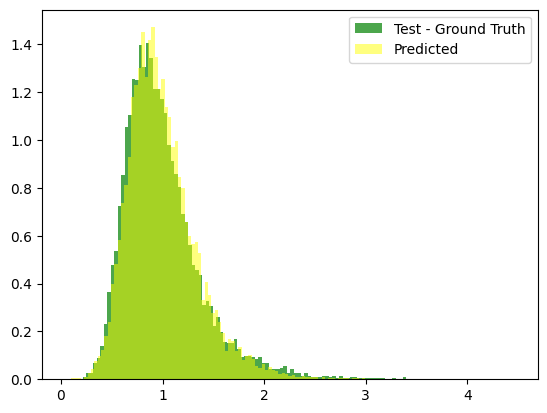

Test:
MAE: 0.39
KS statistics: 0.04


In [67]:
print('Evaluating the models on test set...')

dist_test = model(X_test)
mae_test, ks_statist_test = sample_metrics(dist_test, y_test, 'Test - Ground Truth', 'yellow')
print('Test:')
print(f'MAE: {mae_test:.2f}')
print(f'KS statistics: {ks_statist_test:.2f}')

test_no_guess = ['Test', mae_test, ks_statist_test]
results.loc[2] = test_no_guess

In [68]:
display(results)

,Split,MAE,KS statistics
0,Train,0.382618,0.020479
1,Validation,0.367434,0.024736
2,Test,0.385193,0.038858


* Distribution mean - confidence interval 

Evaluation based on confidence intervals..


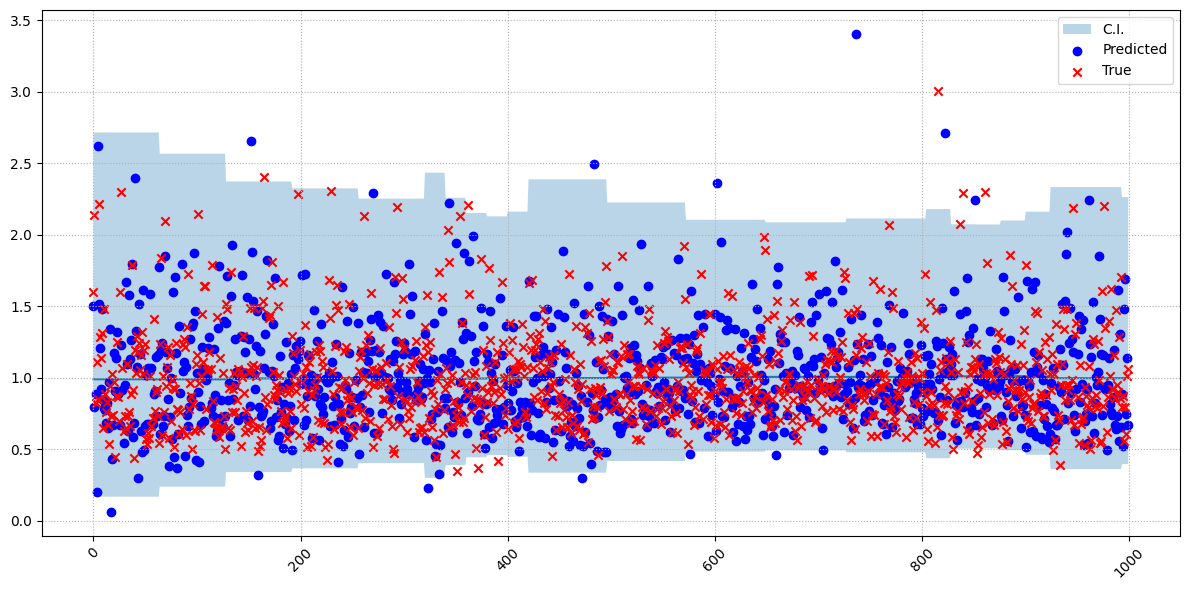

Percentage of values inside the 99% confidence interval: 97.36%


In [107]:
confidence = 0.99

print('Evaluation based on confidence intervals..')

inside = percentage_in_ci(inputs_test, y_test, dist_test, confidence, end = 1000)
print(f'Percentage of values inside the {confidence*100:.0f}% confidence interval: {inside:.2f}%')

# Parameters

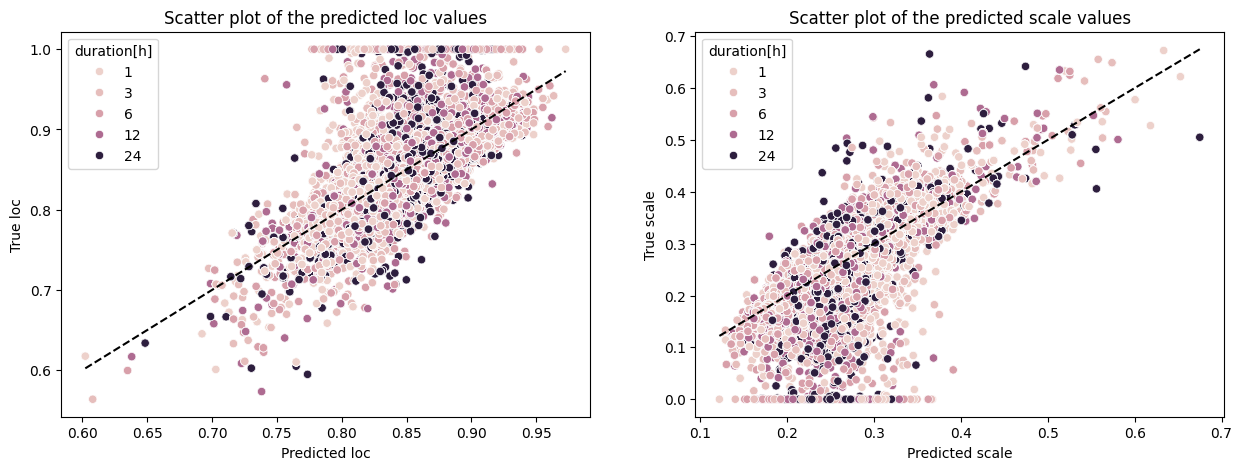

In [70]:
_ = parameters_metrics(dist_train, parameters_train, calculate_metrics = False)

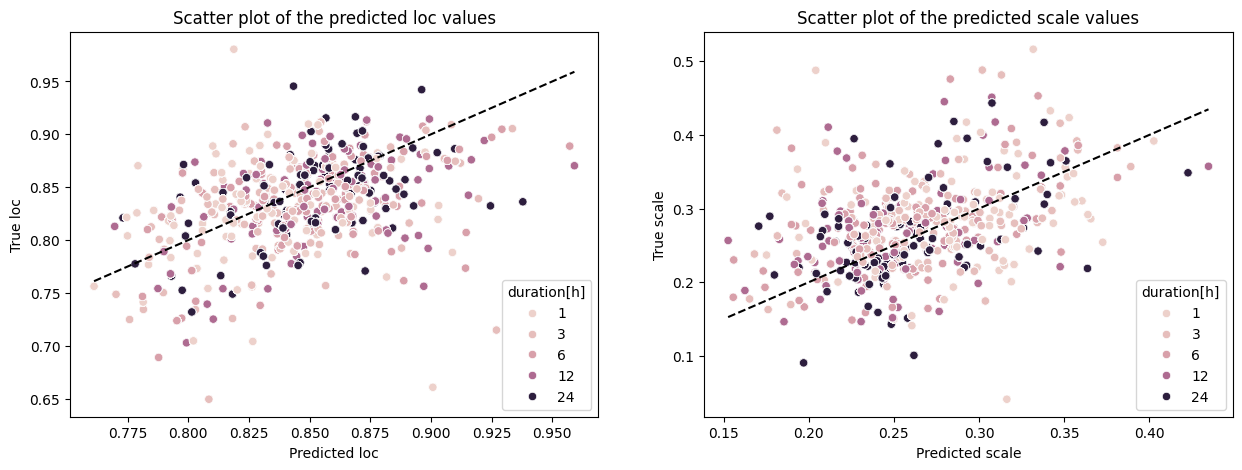

In [71]:
metrics_loc_durations, metrics_scale_durations = parameters_metrics(dist_test, parameters_test, durations_indexes_test, remove_outliers = False)

In [72]:
print('===============LOC PARAMETER===============')
metrics_loc_durations

===============LOC PARAMETER===============


,1,3,6,12,24
biasr,0.005178,-0.014498,-0.010631,-0.023970,-0.021501
rmse,0.023988,0.037573,0.039811,0.044852,0.031195
pcc,0.595027,0.278444,0.590735,0.179978,0.508661


In [73]:
print('===============SCALE PARAMETER==============')
metrics_scale_durations.head()

===============SCALE PARAMETER==============


,1,3,6,12,24
biasr,-0.049483,0.028923,-0.025681,0.051436,0.067656
rmse,0.034281,0.050190,0.053884,0.059718,0.045471
pcc,0.578890,0.288806,0.628143,0.251181,0.508036


* Comparison between two samples extracted from "true" and predicted distribution of the same place 

True loc:  0.7834167698646965 Predicted loc:  0.81384635
True scale:  0.3001078163133484 Predicted scale:  0.3156141


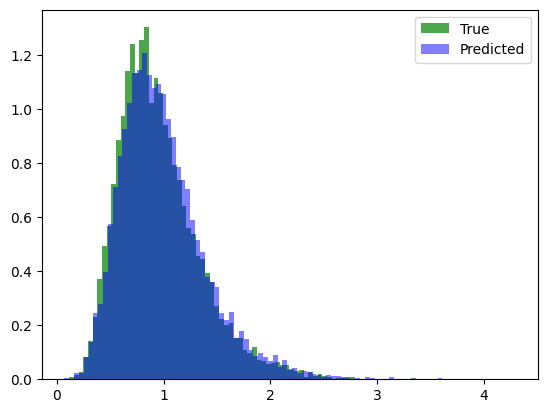

In [74]:
index = 60

loc_pred = dist_train.loc.numpy().ravel()[index]
scale_pred = dist_train.scale.numpy().ravel()[index]

loc_true = parameters_train['loc'][index]
scale_true = parameters_train['scale'][index]

print('True loc: ', loc_true, 'Predicted loc: ', loc_pred)
print('True scale: ', scale_true, 'Predicted scale: ', scale_pred)

samples_pred = stats.gumbel_r.rvs(loc=loc_pred, scale=scale_pred, size=10000)
samples_true = stats.gumbel_r.rvs(loc=loc_true, scale=scale_true, size=10000)

plt.hist(samples_true, bins='auto', alpha=0.7, label='True', density=True, color='green');
plt.hist(samples_pred, bins='auto', alpha=0.5, label='Predicted', density=True, color='blue');
plt.legend()
plt.show()